In [15]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mne
import nibabel as nib
import nilearn.plotting as nplt
from nilearn import datasets, image, plotting
import os
from mne.datasets import fetch_fsaverage
import nibabel as nib
from nilearn import datasets, image, plotting
from scipy.ndimage import binary_fill_holes, distance_transform_edt
from mne_icalabel import label_components
from scipy.stats import rankdata

mne.set_log_level('CRITICAL') 


In [16]:
bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 50)
}

ica_rel_power_baseline = {band: [] for band in bands}
ica_rel_power_condition = {band: [] for band in bands}
all_rel_power_baseline = {band: [] for band in bands}
all_rel_power_condition = {band: [] for band in bands}


############################################################################
# 1) Fetch fsaverage and set up a volume source space
############################################################################
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = fs_dir.parent
subject = 'fsaverage'
# For example, make a 5 mm volumetric grid in the brain:
volume_src = mne.setup_volume_source_space(
    subject=subject,
    pos=5.0,  # mm spacing, can adjust to e.g. 7.0 if you like
    bem=fs_dir / "bem" / "fsaverage-5120-5120-5120-bem-sol.fif",
    subjects_dir=subjects_dir,
    mindist=5.0,  # exclude points too close to inner skull
    add_interpolator=True,
    verbose=False
)

for subject in range(1, 12):
    print("On Subject", subject, "\n\n\n\n")

    
    analysis_type = "psych"  # Choose "psych" or "control"


    base_dir = "C:\\Users\\User\\Desktop\\BCI Psych\\Data"
    subject_folder = os.path.join(base_dir, f"Subject {subject}")
    baseline_file = os.path.join(subject_folder, f"Subject{subject}_{analysis_type}_bl.edf")
    condition_file = os.path.join(subject_folder, f"Subject{subject}_{analysis_type}_condition.edf")
    baseline = mne.io.read_raw_edf(baseline_file, preload=True)

    condition = mne.io.read_raw_edf(condition_file, preload=True)

    print(f"Loaded files:\nBaseline: {baseline_file}\nCondition: {condition_file}")
    montage = mne.channels.make_standard_montage('standard_1020')
    baseline.set_montage(montage)
    baseline.set_eeg_reference('average', projection=True, verbose =None)  # add average-ref projector
    baseline.apply_proj()  # actually apply the projector to the data


    condition.set_montage(montage)
    condition.set_eeg_reference('average', projection=True, verbose =None)  # add average-ref projector
    condition.apply_proj()  # actually apply the projector to the data


    ############################################################################
    # 2) Make the forward solution with the volume source space
    ############################################################################
    fwd = mne.make_forward_solution(
        info=baseline.info,      # or evoked.info, etc.
        trans='fsaverage',  # built-in fsaverage transform
        src=volume_src,
        bem=fs_dir / "bem" / "fsaverage-5120-5120-5120-bem-sol.fif",
        eeg=True, 
        mindist=5.0,
        verbose=False

    )
    ############################################################################
    # 3) Compute noise covariance and create the inverse operator
    ############################################################################
    noise_cov = mne.compute_raw_covariance(baseline, method='shrunk', rank=None, picks='eeg')
    inverse_operator = mne.minimum_norm.make_inverse_operator(
        info=baseline.info,
        forward=fwd,
        noise_cov=noise_cov,
        loose='auto',  # typically 0.0 or None for volumetric
        depth=0.8
    )
    ica = mne.preprocessing.ICA(n_components=0.999999, method='infomax', fit_params=dict(extended=True), random_state=40)
    ica.fit(baseline)


    labels = label_components(baseline, ica, method="iclabel")


    ica.exclude = []

    for comp_idx, label in enumerate(labels["labels"]):
        prob_vector = labels["y_pred_proba"][comp_idx]

        brain_prob = prob_vector  # 'brain' is always the first class

        if label != "brain" or brain_prob < 0.70:
            ica.exclude.append(comp_idx)

    print("Keeping only brain components with ≥ 90% probability.")

    kept_components = [i for i in range(len(labels["labels"])) if i not in ica.exclude]


    ics_of_interest = kept_components



    # Fetch Harvard-Oxford atlas
    atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-1mm")
    atlas_img = atlas.maps
    atlas_labels = atlas.labels

    # Find the PCC region index
    pcc_index = atlas_labels.index("Cingulate Gyrus, posterior division")

    # Extract PCC mask and convert it to a binary mask
    pcc_mask = image.math_img(f"img == {pcc_index}", img=atlas_img)
    pcc_data = np.squeeze(pcc_mask.get_fdata()) > 0

    # Fill the PCC mask to ensure a solid region
    pcc_filled = binary_fill_holes(pcc_data)
    distance_map = distance_transform_edt(1 - pcc_filled)

    overlap_results = []

    for ic_index in ics_of_interest:
        component_maps = ica.get_components()
        scalp_map = component_maps[:, ic_index]  

        evoked_data = scalp_map[:, np.newaxis]  
        evoked = mne.EvokedArray(evoked_data, ica.info, tmin=0)
        evoked.comment = f'IC {ic_index} scalp map'

        stc_vol = mne.minimum_norm.apply_inverse(
            evoked, inverse_operator, lambda2=1.0/9.0, method='eLORETA'
        )

        stc_vol.save_as_volume(
            'my_volume_stc2.nii.gz',
            src=volume_src,
            dest='mri',
            mri_resolution=True,
            overwrite=True
        )

        img = nib.load('my_volume_stc2.nii.gz')

        # Resample the IC activation image to match the PCC mask resolution.
        img_resampled = image.resample_to_img(
            img, pcc_mask, interpolation="linear", force_resample=True, copy_header=True
        )

        # Get continuous IC activation data, clip negatives, and normalize to [0,1]
        ic_data_cont = np.squeeze(img_resampled.get_fdata())
        ic_data_cont = np.clip(ic_data_cont, 0, None)
        if np.max(ic_data_cont) > 0:
            ic_data_norm = ic_data_cont / np.max(ic_data_cont)
        else:
            ic_data_norm = ic_data_cont

        threshold_value = np.percentile(ic_data_cont[ic_data_cont != 0], 90)
        ic_data_bin = (ic_data_cont > threshold_value).astype(int)
        intersection = np.logical_and(ic_data_bin, pcc_filled).sum()
        if (ic_data_bin.sum() + pcc_filled.sum()) > 0:
            dice = (2. * intersection) / (ic_data_bin.sum() + pcc_filled.sum())
        else:
            dice = 0

        # Compute the weighted mean distance from the IC activation to the PCC
        # Weight the distance transform by the normalized activation.
        if np.sum(ic_data_norm) > 0:
            mean_distance = np.sum(ic_data_norm * distance_map) / np.sum(ic_data_norm)
        else:
            mean_distance = np.inf

        overlap_results.append((ic_index, dice, mean_distance))


    dice_array = np.array([entry[1] for entry in overlap_results])
    mean_distance_array = np.array([entry[2] for entry in overlap_results])

    dice_ranks = rankdata(dice_array, method='average')
    norm_dice = (dice_ranks - np.min(dice_ranks)) / (np.max(dice_ranks) - np.min(dice_ranks))


    distance_ranks = rankdata(-mean_distance_array, method='average')
    norm_distance = (distance_ranks - np.min(distance_ranks)) / (np.max(distance_ranks) - np.min(distance_ranks))

    combined_similarity = (norm_dice + norm_distance) / 2

    combined_results = [
        (entry[0], entry[1], entry[2], combined_similarity[i])
        for i, entry in enumerate(overlap_results)
    ]


    ic_of_interest, best_dice, best_distance, best_similarity = max(combined_results, key=lambda x: x[3])

    baseline_data_ica = ica.get_sources(baseline).pick([ic_of_interest]) 
    condition_data_ica = ica.get_sources(condition).pick([ic_of_interest]) 
    baseline_spectrum = baseline_data_ica.compute_psd(fmin=1, fmax=50, picks = 'misc')
    condition_spectrum = condition_data_ica.compute_psd(fmin=1, fmax=50,picks = 'misc')
    chosen = ["P3", "P1", "P2", "P4", "PO3", "POz", "PO4", "O1", "Oz", "O2"]
    baseline_spectrum_noICA = baseline.compute_psd(fmin=1, fmax=50, picks = chosen)
    condition_spectrum_noICA = condition.compute_psd(fmin=1, fmax=50, picks = chosen)

    # Define frequency bands


    # Function to compute absolute and relative band power
    def compute_relative_band_power(psd, freqs):
        absolute_power = {}
        
        for band, (fmin, fmax) in bands.items():
            band_mask = (freqs >= fmin) & (freqs <= fmax)  # Select frequencies within the band
            absolute_power[band] = np.mean(psd[:, band_mask], axis=1)  # Mean across selected freqs
        

        # Compute total power across all bands
        total_power = sum(absolute_power.values())

        
        # Compute relative power
        relative_power = {}

        # Compute relative power for each band
        for band, power in absolute_power.items():
            relative_power[band] = power / total_power
        
        return absolute_power, relative_power

    # Compute relative power for ICA-corrected data
    freqs_baseline = baseline_spectrum.freqs
    freqs_condition = condition_spectrum.freqs
    abs_power_baseline, rel_power_baseline = compute_relative_band_power(baseline_spectrum.get_data(), freqs_baseline)
    abs_power_condition, rel_power_condition = compute_relative_band_power(condition_spectrum.get_data(), freqs_condition)

    # Compute relative power for non-ICA corrected data
    freqs_baseline_noICA = baseline_spectrum_noICA.freqs
    freqs_condition_noICA = condition_spectrum_noICA.freqs
    abs_power_baseline_noICA, rel_power_baseline_noICA = compute_relative_band_power(baseline_spectrum_noICA.get_data(), freqs_baseline_noICA)
    abs_power_condition_noICA, rel_power_condition_noICA = compute_relative_band_power(condition_spectrum_noICA.get_data(), freqs_condition_noICA)

    # Band labels
    bands_list = list(bands.keys())

    for band in bands:
        ica_rel_power_baseline[band].append(rel_power_baseline[band].mean())
        ica_rel_power_condition[band].append(rel_power_condition[band].mean())
        all_rel_power_baseline[band].append(rel_power_baseline_noICA[band].mean())
        all_rel_power_condition[band].append(rel_power_condition_noICA[band].mean())



avg_baseline_ica = [np.mean(ica_rel_power_baseline[band]) for band in bands]
avg_condition_ica = [np.mean(ica_rel_power_condition[band]) for band in bands]
avg_baseline_all= [np.mean(all_rel_power_baseline[band]) for band in bands]
avg_condition_all = [np.mean(all_rel_power_condition[band]) for band in bands]




0 files missing from root.txt in C:\Users\User\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\User\mne_data\MNE-fsaverage-data\fsaverage
On Subject 1 




Loaded files:
Baseline: C:\Users\User\Desktop\BCI Psych\Data\Subject 1\Subject1_psych_bl.edf
Condition: C:\Users\User\Desktop\BCI Psych\Data\Subject 1\Subject1_psych_condition.edf
Keeping only brain components with ≥ 90% probability.
[get_dataset_dir] Dataset found in C:\Users\User\nilearn_data\fsl
On Subject 2 




Loaded files:
Baseline: C:\Users\User\Desktop\BCI Psych\Data\Subject 2\Subject2_psych_bl.edf
Condition: C:\Users\User\Desktop\BCI Psych\Data\Subject 2\Subject2_psych_condition.edf
Keeping only brain components with ≥ 90% probability.
[get_dataset_dir] Dataset found in C:\Users\User\nilearn_data\fsl
On Subject 3 




Loaded files:
Baseline: C:\Users\User\Desktop\BCI Psych\Data\Subject 3\Subject3_psych_bl.edf
Condition: C:\Users\User\Desktop\BCI Psych\Data\Subject 3\Subject3_psych_condition.edf
Keeping

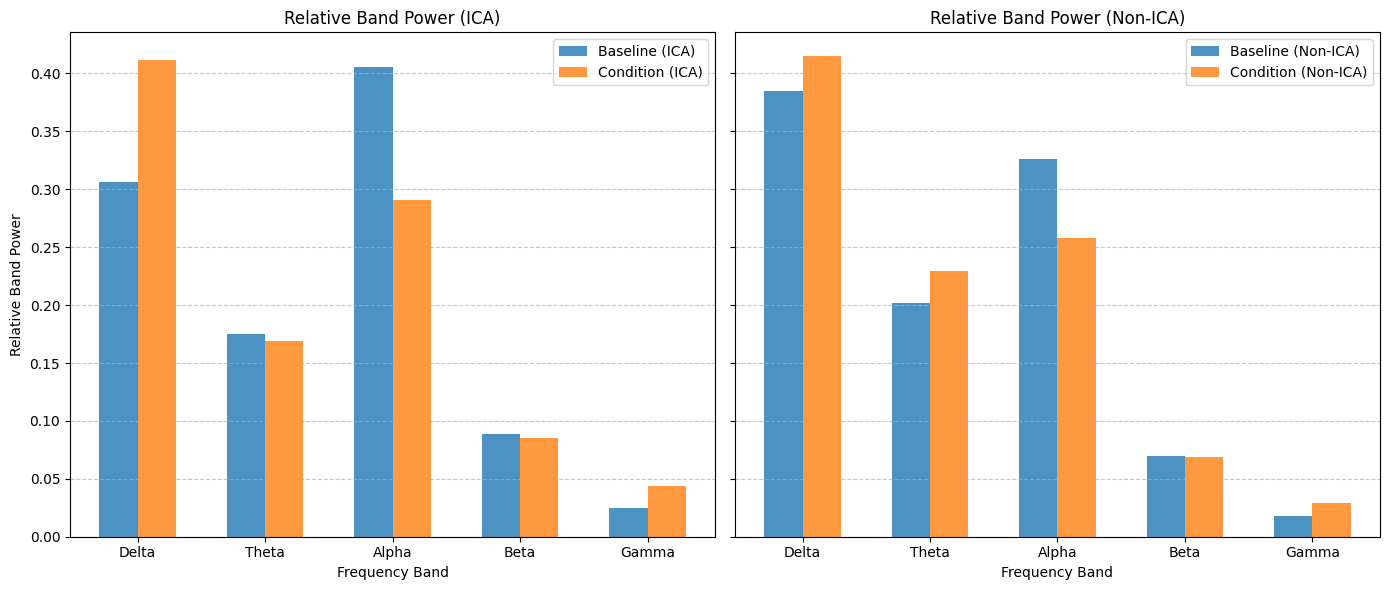

In [17]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Bar width and positions
x = np.arange(len(bands_list))  # Band positions
width = 0.3  # Width of each bar

# Plot for ICA-corrected data
axes[0].bar(x - width/2, avg_baseline_ica, width, label='Baseline (ICA)', alpha=0.8)
axes[0].bar(x + width/2, avg_condition_ica, width, label='Condition (ICA)', alpha=0.8)
axes[0].set_xlabel("Frequency Band")
axes[0].set_ylabel("Relative Band Power")
axes[0].set_title("Relative Band Power (ICA)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(bands_list)
axes[0].legend()
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot for Non-ICA data
axes[1].bar(x - width/2, avg_baseline_all, width, label='Baseline (Non-ICA)', alpha=0.8)
axes[1].bar(x + width/2, avg_condition_all, width, label='Condition (Non-ICA)', alpha=0.8)
axes[1].set_xlabel("Frequency Band")
axes[1].set_title("Relative Band Power (Non-ICA)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(bands_list)
axes[1].legend()
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [18]:
from scipy.spatial import distance

baseline_ica = avg_baseline_ica
condition_ica = avg_condition_ica
baseline_noica = avg_baseline_all
condition_noica = avg_condition_all

# Euclidean distance for ICA
euclidean_distance_ica = distance.euclidean(baseline_ica, condition_ica)
print("Euclidean Distance (ICA):", euclidean_distance_ica)

# Euclidean distance for Non-ICA
euclidean_distance_noica = distance.euclidean(baseline_noica, condition_noica)
print("Euclidean Distance (Non-ICA):", euclidean_distance_noica)

# Compute the difference
differential = euclidean_distance_ica - euclidean_distance_noica
print("Differential:", differential)

# Compute the percent difference
percent_increase = (differential / abs(euclidean_distance_noica)) * 100
print("Percent Increase:", percent_increase, "%")


Euclidean Distance (ICA): 0.15751240914873857
Euclidean Distance (Non-ICA): 0.08043303870539466
Differential: 0.07707937044334391
Percent Increase: 95.83048419402085 %
